In [20]:
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import scipy.stats as stats
from matplotlib import gridspec
import aplpy as apl #The Astronomy Plotting Library for python
import astropy
from astropy.stats import sigma_clip
from astropy.modeling import functional_models, models, fitting
import astropy.units as U
from astropy.coordinates import ICRS, Galactic, FK4, FK5, Angle, Latitude, Longitude
import astropy.constants as C
from astropy import wcs
import astropy.io.fits as fits
from astropy.io import ascii
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.stats import signal_to_noise_oir_ccd as SNRas
#import spectral_cube as SC
#from spectral_cube import SpectralCube as sc
from astropy.wcs import WCS
matplotlib.use('Agg')
import matplotlib.cm as cm
#import astrometry as ast
import pyfits
import requests
import json
import os
from sklearn import datasets, linear_model
from scipy.optimize import curve_fit
import numpy.ma as ma
from astropy.table import Table, Column
import pyextract
import sewpy
import pandas as pd
#import alipy

In [21]:
quasJ = os.listdir('/../home/lynge/MasterP/NGC3783/NGC3783g/')
quasJ = [os.path.join('/../home/lynge/MasterP/NGC3783/NGC3783g',f) \
        for f in os.listdir('/../home/lynge/MasterP/NGC3783/NGC3783g/')]

qua1_RA_WORLD = 174.75717083
qua1_DEC_WORLD = -37.73850000
sta1_RA_WORLD = 174.77413750 - 9*10**(-5) #HD 101274
sta1_DEC_WORLD = -37.75375000 + 6.4*10**(-5)
sta2_RA_WORLD = 174.82283333 - 0.15/3600. #Tycho-2 7740-22-1
sta2_DEC_WORLD = -37.76239167
sta3_RA_WORLD = 174.79553333 #174.79553250 #Tycho-2 7740-529-1
sta3_DEC_WORLD = -37.83470278 #-37.83470333
gal_RA_WORLD = 174.69151250 + 0.6/3600.# Galaxy
gal_DEC_WORLD = -37.71181944 + 0.4/3600

sky_RA_WORLD = 174.75445032458904 #Random patch of sky
sky_DEC_WORLD = -37.77465736280882

MAG_HD101274_B = 9.23
MAG_HD101274_V = 9.12
MAG_HD101274_G = 9.192
MAG_HD101274_J = 8.997
MAG_HD101274_H = 8.982
MAG_HD101274_K = 8.909

MAG_TYCHO_2_7740_22_1_B = 12.58
MAG_TYCHO_2_7740_22_1_V = 12.12
MAG_TYCHO_2_7740_22_1_G = 11.78
MAG_TYCHO_2_7740_22_1_J = 10.919
MAG_TYCHO_2_7740_22_1_H = 10.726
MAG_TYCHO_2_7740_22_1_K = 10.611

MAG_TYCHO_2_7740_529_1_B = 11.61
MAG_TYCHO_2_7740_529_1_V = 10.94
MAG_TYCHO_2_7740_529_1_G = 10.867
MAG_TYCHO_2_7740_529_1_J = 9.902
MAG_TYCHO_2_7740_529_1_H = 9.625
MAG_TYCHO_2_7740_529_1_K = 9.580

MAG_VEGA_B = 0.03
MAG_VEGA_V = 0.03
MAG_VEGA_G = 0.03
MAG_VEGA_J = -0.18
MAG_VEGA_H = -0.03
MAG_VEGA_K = 0.13

FLUX_LAMBDA_VEGA_B = 632*10**(-11) #erg/cm**2/s/A
FLUX_LAMBDA_VEGA_V = 363.1*10**(-11)
FLUX_LAMBDA_VEGA_G = float('nan')
FLUX_LAMBDA_VEGA_J = 31.47*10**(-11)
FLUX_LAMBDA_VEGA_H = 11.38*10**(-11)
FLUX_LAMBDA_VEGA_K = 3.961*10**(-11)

FLUX_V_VEGA_B = 4.063*10**(-20) #erg/cm**2/s/Hz
FLUX_V_VEGA_V = 3.636*10**(-20)
FLUX_V_VEGA_G = float('nan')
FLUX_V_VEGA_J = 1.589*10**(-20)
FLUX_V_VEGA_H = 1.021*10**(-20)
FLUX_V_VEGA_K = 0.64*10**(-20)

In [22]:
def dist(mid,end):
    return np.sqrt((mid[0] - end[0])**2 + (mid[1] - end[1])**2)

In [23]:
def flux_cal(A_mag,B_mag,B_flux):
    '''Flux of A found through magnitude and flux of B'''
    return B_flux*10**((B_mag-A_mag)/2.5)

In [24]:
def Basic(quasar,header):
    '''Provides a basic list of neccesities from the fits header file for use in the later \
    flux determination, it does not serve an individual purpose beyound that'''
    AGNdata = quasar #np.rot90(np.rot90(np.fliplr(quasar)))
    #header = data[0].header
    #print header
    RAstd = header['CRVAL1']
    DECstd = header['CRVAL2']
    #print RAstd, DECstd
    pixspa = header['PIXSCALE']/(3600.)
    #print pixspa
    RAstdpix = header['CRPIX1']
    DECstdpix = header['CRPIX2']
    exptime = 10 # header['EXPTIME']
    return header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime

In [25]:
def curve(quasar,header,w,center,apparature):
    '''Determines the FLUX of the stellar object given the the numpy array of the image, \
    the header of the fits file, the astropy coordinate representation, \
    the object position and the apparature of interest'''
    header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime = Basic(quasar,header)
    #AGNdata = np.swapaxes(AGNdata,0,1)
    y, x = np.ogrid[0:header['NAXIS1'],0:header['NAXIS1']]
    #w = np.swapaxes(w,0,1)
    #F_AGN = np.zeros((512,512,3)) #((int(2*apparature/pixspa)+1,int(2*apparature/pixspa)+1,3))
    #print center
    x1 = w.all_world2pix(center[0],center[1],0)
    x1,y1 = (x1[0]),(x1[1])
    if 15 < x1 < header['NAXIS1'] - 15 and 15 < y1 < header['NAXIS2'] - 15:
        try:
            mask = ((y-y1)**2 + (x-x1)**2) > (apparature/float(pixspa))**2
            AGNdata[mask] = float(0)
            mask = AGNdata == 0.
            rows = np.flatnonzero((~mask).sum(axis=1))
            cols = np.flatnonzero((~mask).sum(axis=0))
            AGNdata = AGNdata[rows.min():rows.max()+1, cols.min():cols.max()+1]
            #print apparature/float(pixspa)
        except:
            AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    else:
        AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    #if np.sum(AGNdata) < 500:
    #    AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    return AGNdata, x1, y1


In [26]:
def comp1(qua,sta):
    '''Code to determine the relation between the AGN and the Stellar flux as determined by either me \
    or by the SExtractor program respectively'''
    comp = qua/sta
    return comp

In [27]:
def SXtable(quas,aperture):
    header = pyfits.getheader(quas)
    phot_app = aperture*3600/header['PIXSCALE']
    np.set_printoptions(threshold=np.inf)
    sew = sewpy.SEW(params=['XMODEL_WORLD', 'YMODEL_WORLD', 'X2MODEL_WORLD', 'Y2MODEL_WORLD', 
                            'XMODEL_IMAGE', 'YMODEL_IMAGE', 'FLUX_RADIUS(1)', 'FLUX_PSF','ELLIPTICITY'],
                    config={"DETECT_THRESH":10, 'DETECT_MINAREA':50, 'DETECT_MAXAREA':30000, 
                            "PHOT_FLUXFRAC":"0.5", 'PHOT_APERTURES':2*phot_app, 
                            'PIXEL_SCALE':header['PIXSCALE']}
                    , sexpath='/usr/bin/sextractor')
    out = sew(quas)
    return out

In [28]:
def flux(quas,aperture,main_RA_WORLD,main_DEC_WORLD):
    header = pyfits.getheader(quas)
    RAmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,1)[0]
    DECmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,1)[1]
    output = float('nan')
    if 15 < RAmain < header['NAXIS1'] - 15 and 15 < DECmain < header['NAXIS2'] - 15: 
        out = SXtable(quas,aperture)
        RAmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,0)[0]
        DECmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,0)[1]
        #print out['table']['XMODEL_IMAGE'], out['table']['YMODEL_IMAGE']
        #print RAmain, DECmain

        for j in range(len(out['table']['XMODEL_IMAGE'])):
            #output['time'][i] = header['MJD-OBS']
            if RAmain - 20. < out['table']['XMODEL_IMAGE'][j] <  RAmain + 20. and \
            DECmain - 20. < out['table']['YMODEL_IMAGE'][j] < DECmain + 20.:
                #print 'YES'
                output = out['table']['FLUX_PSF'][j]
                break
    else:
        output = float('nan')
        #print 'Done'
    return output


In [29]:
def SNR(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = data2
    
    return float(header['GAIN'])*data1_2*header['EXPTIME']/(np.sqrt
                                                        (float(header['GAIN'])*data1_2*header['EXPTIME'] 
                                                         + float(header['GAIN'])*npix1*data2_2*header['EXPTIME']
                                                         +npix1*header['RONOISE']**2))
#SNRas(10.,data1_2,abs(data2_2),0,header['RON'],npix1,gain=header['GAIN'])

for i in range(len(quasJ)):
    print i
    data1, header = fits.getdata(quasJ[i],header=True) #RA---TAN
    data2 = data1
    #print header['CTYPE2']
    header['CTYPE1'] = "RA---TAN -SIP"
    header['CTYPE2'] = "DEC--TAN -SIP"
    #a_sky = curve(data2,header,WCS(quasJ[i]),
    #               (sky_RA_WORLD,sky_DEC_WORLD),0.002)[0]
    #a_sky_mean = np.mean(a_sky)
    #for j in range(len(np.shape(data[0]))):
    #    for k in range(len(np.shape(data[0]))):
    #        if data[j,k] != 0:
    #            data[j,k] = float(data[j,k]) - a_sky_mean
    #header['NDIT'] = 5
    '''header['A_ORDER'] = "0"
    header['B_ORDER'] = "0"
    header['AP_ORDER'] = "0"
    header['BP_ORDER'] = "0"
    header['A_0_2'] = "0"
    header['A_1_1'] = "0"
    header['A_2_0'] = "0"
    header['B_0_2'] = "0"
    header['B_1_1'] = "0"
    header['B_2_0'] = "0"
    header['AP_0_2'] = "0"
    header['AP_1_1'] = "0"
    header['AP_2_0'] = "0"
    header['AP_0_1'] = "0"
    header['AP_1_0'] = "0"
    header['BP_0_1'] = "0"
    header['BP_0_2'] = "0"
    header['BP_1_0'] = "0"
    header['BP_1_1'] = "0"
    header['BP_2_0'] = "0"'''
    fits.writeto(quasJ[i],data1,header,clobber=True)
    #print fits.getheader(quasH[i])['A_ORDER']

In [30]:
a = np.array([[0,2],
              [3,4]])
b = np.mean(np.array([[1,2,3],
                      [2,2,2],
                      [1,1,1]]))

a = a.astype(float)
mask = a != 0.
a[mask] = a[mask] - float(b)
print a

[[ 0.          0.33333333]
 [ 1.33333333  2.33333333]]


In [31]:
def SEXAGNflux(quas,aperture1):
    aperture2 = aperture1 + 0.003
    date = []
    flucompsta1 = []
    flucompsta2 = []
    flucompsta3 = []
    flucompsta4 = []
    flucompsta5 = []
    flucompsta6 = []
    flucompsta7 = []
    poissonAGN = []
    poisson529 = []
    poisson22 = []
    poissonHD = []
    ABS_FLUX_LAMBDA_1 = 0
    ABS_FLUX_LAMBDA_2 = 0
    ABS_FLUX_LAMBDA_3 = 0
    ABS_FLUX_V_1 = 0
    ABS_FLUX_V_2 = 0
    ABS_FLUX_V_3 = 0
    SNR_comp = []
    comp_array = np.zeros((len(quas),7))
    SNR_array = np.zeros((len(quas),8))
    #-----------------------------------------------------------------------------------------------
    for i in range(len(quas)):
        print 'Frame nr. ', i, quas[i]
        header = pyfits.getheader(quas[i])
        a_AGN = flux(quas[i],2*aperture1,qua1_RA_WORLD,qua1_DEC_WORLD)/header['EXPTIME']
        a2 = flux(quas[i],2*aperture1,sta1_RA_WORLD,sta1_DEC_WORLD)/header['EXPTIME']
        a3 = flux(quas[i],2*aperture1,sta2_RA_WORLD,sta2_DEC_WORLD)/header['EXPTIME']
        a4 = flux(quas[i],2*aperture1,sta3_RA_WORLD,sta3_DEC_WORLD)/header['EXPTIME']
        a_sky = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sky_RA_WORLD,sky_DEC_WORLD),aperture1)[0]/header['EXPTIME']
        #a_AGN_1 = flux(quas[i],2*aperture2,qua1_RA_WORLD,qua1_DEC_WORLD)/header['DIT']
        #a2_1 = flux(quas[i],2*aperture2,sta1_RA_WORLD,sta1_DEC_WORLD)/header['DIT']
        #a3_1 = flux(quas[i],2*aperture2,sta2_RA_WORLD,sta2_DEC_WORLD)/header['DIT']
        #a4_1 = flux(quas[i],2*aperture2,sta3_RA_WORLD,sta3_DEC_WORLD)/header['DIT']
        #-------------------------------------------------------------------------------------------
        #plt.figure(figsize=(3,3))
        #plt.imshow(a2)
        #plt.show()
        #-------------------------------------------------------------------------------------------
        a_AGN_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a2_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a3_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a4_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a_sky_pix = np.count_nonzero(a_sky)
        a_sky_2 = np.sum(a_sky)/float(np.count_nonzero(a_sky))
        #a_AGN_pix_1 = np.pi*(2*aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a2_pix_1 = np.pi*(aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a3_pix_1 = np.pi*(aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a4_pix_1 = np.pi*(aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a_AGN_2 = (np.sum(a_AGN_1) - np.sum(a_AGN))/(float(np.count_nonzero(a_AGN_1)) - float(np.count_nonzero(a_AGN)))
        #a2_2 = (np.sum(a2_1) - np.sum(a2))/(float(np.count_nonzero(a2_1)) - float(np.count_nonzero(a2)))
        #a3_2 = (np.sum(a3_1) - np.sum(a3))/(float(np.count_nonzero(a3_1)) - float(np.count_nonzero(a3)))
        #a4_2 = (np.sum(a4_1) - np.sum(a4))/(float(np.count_nonzero(a4_1)) - float(np.count_nonzero(a4)))
        a_AGN_3 = a_AGN/a_AGN_pix #- (a_AGN_1 - a_AGN)/(a_AGN_pix_1 - a_AGN_pix) #Background subtracted flux/pixel/sec
        a2_3 = a2/a2_pix #- (a2_1 - a2)/(a2_pix_1 - a2_pix)
        a3_3 = a3/a3_pix #- (a3_1 - a3)/(a3_pix_1 - a3_pix)
        a4_3 = a4/a4_pix #- (a4_1 - a4)/(a4_pix_1 - a4_pix)
        #-------------------------------------------------------------------------------------------
        date.append(header['MJD-OBS'])
        #-------------------------------------------------------------------------------------------
        poissonAGN.append(np.sqrt(np.sum(a_AGN)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        poissonHD.append(np.sqrt(np.sum(a2)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        poisson22.append(np.sqrt(np.sum(a3)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        poisson529.append(np.sqrt(np.sum(a4)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        #-------------------------------------------------------------------------------------------
        #if SNR1[i] < 70:
        #    flucompsta_AGN.append(float('nan'))
        #    flucompsta2.append(float('nan'))
        #    flucompsta3.append(float('nan'))
        #    flucompsta4.append(float('nan'))
        #    flucompsta6.append(float('nan'))
        #    comp_array[i,0] = int(date[i])
        #    comp_array[i,1] = float('nan')
        #    comp_array[i,2] = float('nan')
        #    comp_array[i,3] = float('nan')
        #else:
        flucompsta1.append(comp1(a_AGN_3,a2_3))
        flucompsta2.append(comp1(a_AGN_3,a3_3))
        flucompsta3.append(comp1(a_AGN_3,a4_3))
        #flucompsta4.append(comp1(a_AGN_3,a5_3))
        #flucompsta5.append(comp1(a_AGN_3,a6_3))
        #flucompsta6.append(comp1(a_AGN_3,a7_3))
        comp_array[i,0] = int(date[i])
        comp_array[i,1] = flucompsta1[i]
        comp_array[i,2] = flucompsta2[i]
        comp_array[i,3] = flucompsta3[i]
        #comp_array[i,4] = flucompsta4[i]
        #comp_array[i,5] = flucompsta5[i]
        #comp_array[i,6] = flucompsta6[i]
        print a_AGN
        #SNR_array[i,0] = int(date[i])
        #SNR_array[i,1] = SNR(a_AGN,a_sky,header,aperture1,aperture1)
        #SNR_array[i,2] = SNR(a2,a_sky,header,aperture1,aperture1)
        #SNR_array[i,3] = SNR(a3,a_sky,header,aperture1,aperture1)
        #SNR_array[i,4] = SNR(a4,a_sky,header,aperture1,aperture1)
        #SNR_array[i,5] = SNR(a5,a_sky,header,aperture1,aperture1)
        #SNR_array[i,6] = SNR(a6,a_sky,header,aperture1,aperture1)
        #SNR_array[i,7] = SNR(a7,a_sky,header,aperture1,aperture1)
    #print 'YES'
    #-----------------------------------------------------------------------------------------------
    poissonAGN = np.array(poissonAGN)
    poissonHD = np.array(poissonHD)
    poisson22 = np.array(poisson22)
    poisson529 = np.array(poisson529)
    comp_array = comp_array[comp_array[:,0].argsort()]
    #-----------------------------------------------------------------------------------------------
    ABS_FLUX_LAMBDA_1 = np.array(flucompsta1)*flux_cal(MAG_HD101274_K,\
                                                            MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_LAMBDA_2 = np.array(flucompsta2)*flux_cal(MAG_TYCHO_2_7740_22_1_K,\
                                                            MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_LAMBDA_3 = np.array(flucompsta4)*flux_cal(MAG_TYCHO_2_7740_529_1_K,\
                                                            MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_V_1 = np.array(flucompsta1)*flux_cal(MAG_HD101274_K,\
                                                            MAG_VEGA_K,FLUX_V_VEGA_K)
    ABS_FLUX_V_2 = np.array(flucompsta2)*flux_cal(MAG_TYCHO_2_7740_22_1_K,\
                                                            MAG_VEGA_K,FLUX_V_VEGA_K)
    ABS_FLUX_V_3 = np.array(flucompsta4)*flux_cal(MAG_TYCHO_2_7740_529_1_K,\
                                                            MAG_VEGA_K,FLUX_V_VEGA_K)
    #-----------------------------------------------------------------------------------------------
    return comp_array,SNR_array,ABS_FLUX_LAMBDA_1,ABS_FLUX_LAMBDA_2,ABS_FLUX_LAMBDA_3,\
ABS_FLUX_V_1,ABS_FLUX_V_2,ABS_FLUX_V_3,date

In [32]:
comp_array,SNR_array,ABS_FLUX_LAMBDA_1_1,ABS_FLUX_LAMBDA_2_1,ABS_FLUX_LAMBDA_3_1,\
ABS_FLUX_V_1_1,ABS_FLUX_V_2_1,ABS_FLUX_V_3_1,date_1 = SEXAGNflux(quasJ,0.003)

Frame nr.  0 /../home/lynge/MasterP/NGC3783/NGC3783g/IMG2017210URs022.fits
nan
Frame nr.  1 /../home/lynge/MasterP/NGC3783/NGC3783g/IMG2017002URs055.fits


/home/lynge/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


745.408166667
Frame nr.  2 /../home/lynge/MasterP/NGC3783/NGC3783g/IMG2017156URs027.fits
771.938666667
Frame nr.  3 /../home/lynge/MasterP/NGC3783/NGC3783g/IMG2017187URs027.fits
212.964166667
Frame nr.  4 /../home/lynge/MasterP/NGC3783/NGC3783g/IMG2016173URs048.fits
775.29
Frame nr.  5 /../home/lynge/MasterP/NGC3783/NGC3783g/IMG2017062URs066.fits
659.9285
Frame nr.  6 /../home/lynge/MasterP/NGC3783/NGC3783g/IMG2017024URs111.fits
462.7425
Frame nr.  7 /../home/lynge/MasterP/NGC3783/NGC3783g/IMG2016337URs097.fits
943.167166667
Frame nr.  8 /../home/lynge/MasterP/NGC3783/NGC3783g/IMG2016119URs026.fits
816.857333333
Frame nr.  9 /../home/lynge/MasterP/NGC3783/NGC3783g/IMG2017170URs045.fits
1225.97216667
Frame nr.  10 /../home/lynge/MasterP/NGC3783/NGC3783g/IMG2016127URs032.fits
1102.93283333
Frame nr.  11 /../home/lynge/MasterP/NGC3783/NGC3783g/IMG2017031URs111.fits
584.358
Frame nr.  12 /../home/lynge/MasterP/NGC3783/NGC3783g/IMG2016119URs025.fits
858.754833333
Frame nr.  13 /../home/lyng

1288.93716667
Frame nr.  96 /../home/lynge/MasterP/NGC3783/NGC3783g/IMG2017148URs056.fits
227.223
Frame nr.  97 /../home/lynge/MasterP/NGC3783/NGC3783g/IMG2016210URs020.fits
682.872333333
Frame nr.  98 /../home/lynge/MasterP/NGC3783/NGC3783g/IMG2017017URs105.fits
489.0095
Frame nr.  99 /../home/lynge/MasterP/NGC3783/NGC3783g/IMG2017194URs019.fits
463.4335
Frame nr.  100 /../home/lynge/MasterP/NGC3783/NGC3783g/IMG2016344URs089.fits
744.075666667
Frame nr.  101 /../home/lynge/MasterP/NGC3783/NGC3783g/IMG2017140URs025.fits
1011.61866667
Frame nr.  102 /../home/lynge/MasterP/NGC3783/NGC3783g/IMG2016173URs049.fits
827.440833333
Frame nr.  103 /../home/lynge/MasterP/NGC3783/NGC3783g/IMG2017046URs068.fits
435.382333333
Frame nr.  104 /../home/lynge/MasterP/NGC3783/NGC3783g/IMG2016330URs067.fits
409.068333333
Frame nr.  105 /../home/lynge/MasterP/NGC3783/NGC3783g/IMG2016134URs064.fits
278.776666667
Frame nr.  106 /../home/lynge/MasterP/NGC3783/NGC3783g/IMG2017201URs030.fits
958.081833333
Frame

In [33]:
def AGNflux(quas,aperture1):
    aperture2 = aperture1 + 0.001
    date = []
    flucompsta1 = []
    flucompsta2 = []
    flucompsta3 = []
    flucompsta4 = []
    flucompsta5 = []
    flucompsta6 = []
    flucompsta7 = []
    SNR1 = []
    SNR2 = []
    SNR3 = []
    SNR4 = []
    SNR5 = []
    poissonAGN = []
    poisson529 = []
    poisson22 = []
    poissonHD = []
    ABS_FLUX_LAMBDA_1 = 0
    ABS_FLUX_LAMBDA_2 = 0
    ABS_FLUX_LAMBDA_3 = 0
    ABS_FLUX_V_1 = 0
    ABS_FLUX_V_2 = 0
    ABS_FLUX_V_3 = 0
    SNR_comp = []
    for i in range(len(quas)):
        #print 'Frame nr. ', i
        header = pyfits.getheader(quas[i])
        a1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (qua1_RA_WORLD,qua1_DEC_WORLD),aperture1)[0]/header['EXPTIME'] #float(header['EXPTIME'])
        a2 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta1_RA_WORLD,sta1_DEC_WORLD),aperture1)[0]/header['EXPTIME'] #float(header['EXPTIME'])
        a3 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta2_RA_WORLD,sta2_DEC_WORLD),aperture1)[0]/header['EXPTIME'] #float(header['EXPTIME'])
        a4 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta3_RA_WORLD,sta3_DEC_WORLD),aperture1)[0]/header['EXPTIME'] #float(header['EXPTIME'])
        a_sky = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sky_RA_WORLD,sky_DEC_WORLD),aperture1)[0]/header['EXPTIME'] #float(header['EXPTIME'])
        a1_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (qua1_RA_WORLD,qua1_DEC_WORLD),aperture2)[0]/header['EXPTIME'] #float(header['EXPTIME'])
        a2_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta1_RA_WORLD,sta1_DEC_WORLD),aperture2)[0]/header['EXPTIME'] #float(header['EXPTIME'])
        a3_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta2_RA_WORLD,sta2_DEC_WORLD),aperture2)[0]/header['EXPTIME'] #float(header['EXPTIME'])
        a4_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta3_RA_WORLD,sta3_DEC_WORLD),aperture2)[0]/header['EXPTIME'] #float(header['EXPTIME'])
        date.append(header['MJD-OBS'])
        a_AGN_pix = np.pi*(2*aperture1)**2/np.count_nonzero(a1)
        a2_pix = np.pi*(2*aperture1)**2/np.count_nonzero(a2)
        a3_pix = np.pi*(2*aperture1)**2/np.count_nonzero(a3)
        a4_pix = np.pi*(2*aperture1)**2/np.count_nonzero(a4)
        a_AGN_pix_1 = np.pi*(2*aperture1)**2/np.count_nonzero(a1_1)
        a2_pix_1 = np.pi*(2*aperture1)**2/np.count_nonzero(a2_1)
        a3_pix_1 = np.pi*(2*aperture1)**2/np.count_nonzero(a3_1)
        a4_pix_1 = np.pi*(2*aperture1)**2/np.count_nonzero(a4_1)
        a_AGN_3 = np.sum(a1)/a_AGN_pix - (np.sum(a1_1) - np.sum(a1))/(a_AGN_pix_1 - a_AGN_pix)#Background subtracted flux/pixel/sec
        a2_3 = np.sum(a2)/a2_pix - (np.sum(a2_1) - np.sum(a2))/(a2_pix_1 - a2_pix)
        a3_3 = np.sum(a3)/a3_pix - (np.sum(a3_1) - np.sum(a3))/(a3_pix_1 - a3_pix)
        a4_3 = np.sum(a4)/a4_pix - (np.sum(a4_1) - np.sum(a4))/(a4_pix_1 - a4_pix)
        flucompsta1.append(comp1(a_AGN_3,a2_3))
        flucompsta2.append(comp1(a_AGN_3,a3_3))
        flucompsta3.append(comp1(a_AGN_3,a4_3))
        SNR1.append(SNR(np.sum(a1),np.sum(a_sky),header,aperture1,aperture1))
        SNR2.append(SNR(np.sum(a2),np.sum(a_sky),header,aperture1,aperture1))
        SNR3.append(SNR(np.sum(a3),np.sum(a_sky),header,aperture1,aperture1))
        SNR4.append(SNR(np.sum(a4),np.sum(a_sky),header,aperture1,aperture1))
        poissonAGN.append(np.sqrt(np.sum(a1)*header['EXPTIME']))
        poissonHD.append(np.sqrt(np.sum(a2)*header['EXPTIME']))
        poisson22.append(np.sqrt(np.sum(a3)*header['EXPTIME']))
        poisson529.append(np.sqrt(np.sum(a4)*header['EXPTIME']))
        #print header['EXPTIME']
    poissonAGN = np.array(poissonAGN)
    poissonHD = np.array(poissonHD)
    poisson22 = np.array(poisson22)
    poisson529 = np.array(poisson529)
    ABS_FLUX_LAMBDA_1 = np.array(flucompsta1)*flux_cal(MAG_HD101274_K,\
                                                            MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_LAMBDA_2 = np.array(flucompsta2)*flux_cal(MAG_TYCHO_2_7740_22_1_K,\
                                                            MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_LAMBDA_3 = np.array(flucompsta3)*flux_cal(MAG_TYCHO_2_7740_529_1_K,\
                                                            MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_V_1 = np.array(flucompsta1)*flux_cal(MAG_HD101274_K,\
                                                            MAG_VEGA_K,FLUX_V_VEGA_K)
    ABS_FLUX_V_2 = np.array(flucompsta2)*flux_cal(MAG_TYCHO_2_7740_22_1_K,\
                                                            MAG_VEGA_K,FLUX_V_VEGA_K)
    ABS_FLUX_V_3 = np.array(flucompsta3)*flux_cal(MAG_TYCHO_2_7740_529_1_K,\
                                                            MAG_VEGA_K,FLUX_V_VEGA_K)
    return np.array(flucompsta1),np.array(flucompsta2),np.array(flucompsta3),np.array(flucompsta4),\
np.array(flucompsta5),np.array(flucompsta6),np.array(flucompsta7),np.array(SNR1),np.array(SNR2),np.array(SNR3),\
np.array(SNR4),np.array(SNR5),np.array(SNR_comp),ABS_FLUX_LAMBDA_1,ABS_FLUX_LAMBDA_2,ABS_FLUX_LAMBDA_3,\
ABS_FLUX_V_1,ABS_FLUX_V_2,ABS_FLUX_V_3,date,poissonAGN,poissonHD,poisson22,poisson529

In [34]:
flucompsta1,flucompsta2,flucompsta3,flucompsta4,flucompsta5,flucompsta6,flucompsta7,\
SNR1,SNR2,SNR3,SNR4,SNR5,SNR_comp,ABS_FLUX_LAMBDA_1,ABS_FLUX_LAMBDA_2,ABS_FLUX_LAMBDA_3,ABS_FLUX_V_1,\
ABS_FLUX_V_2,ABS_FLUX_V_3,date,poissonAGN,poissonHD,poisson22,poisson529 = AGNflux(quasJ,0.003)

In [35]:
print np.shape(ABS_FLUX_V_3_1), np.shape(date_1)


(0,) (114,)


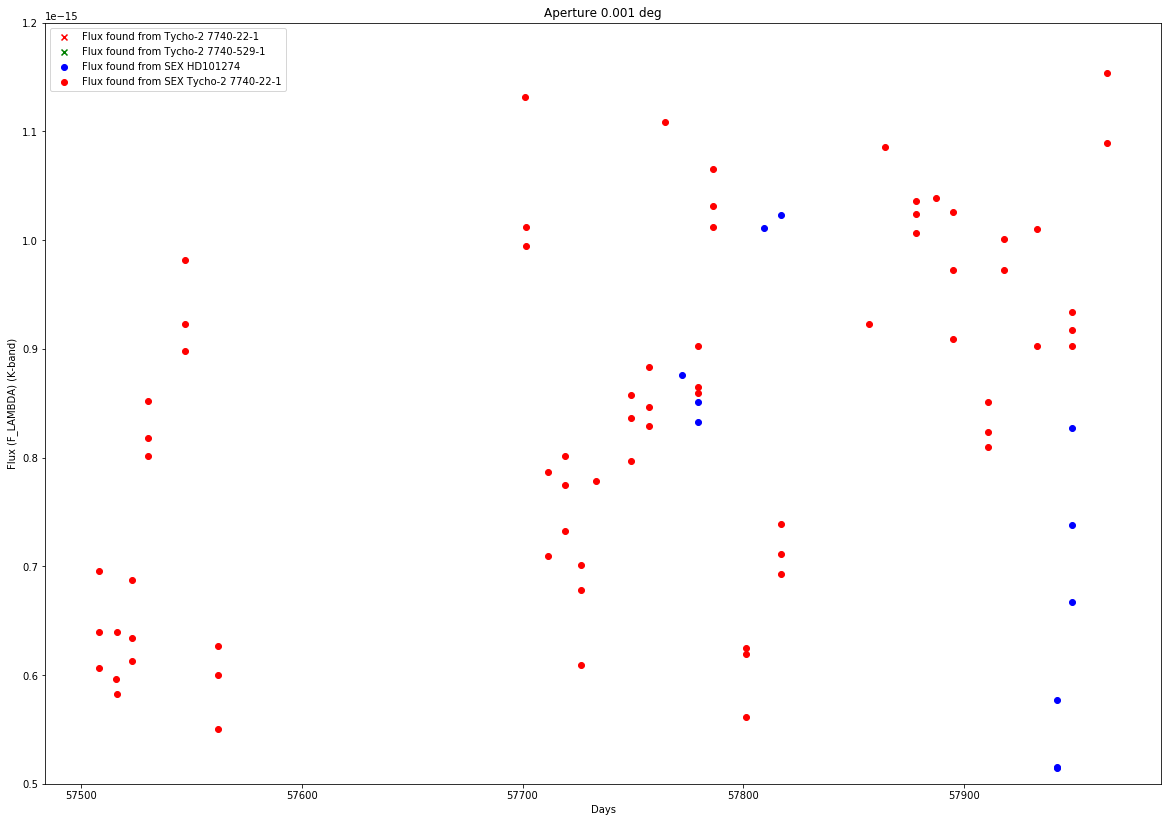

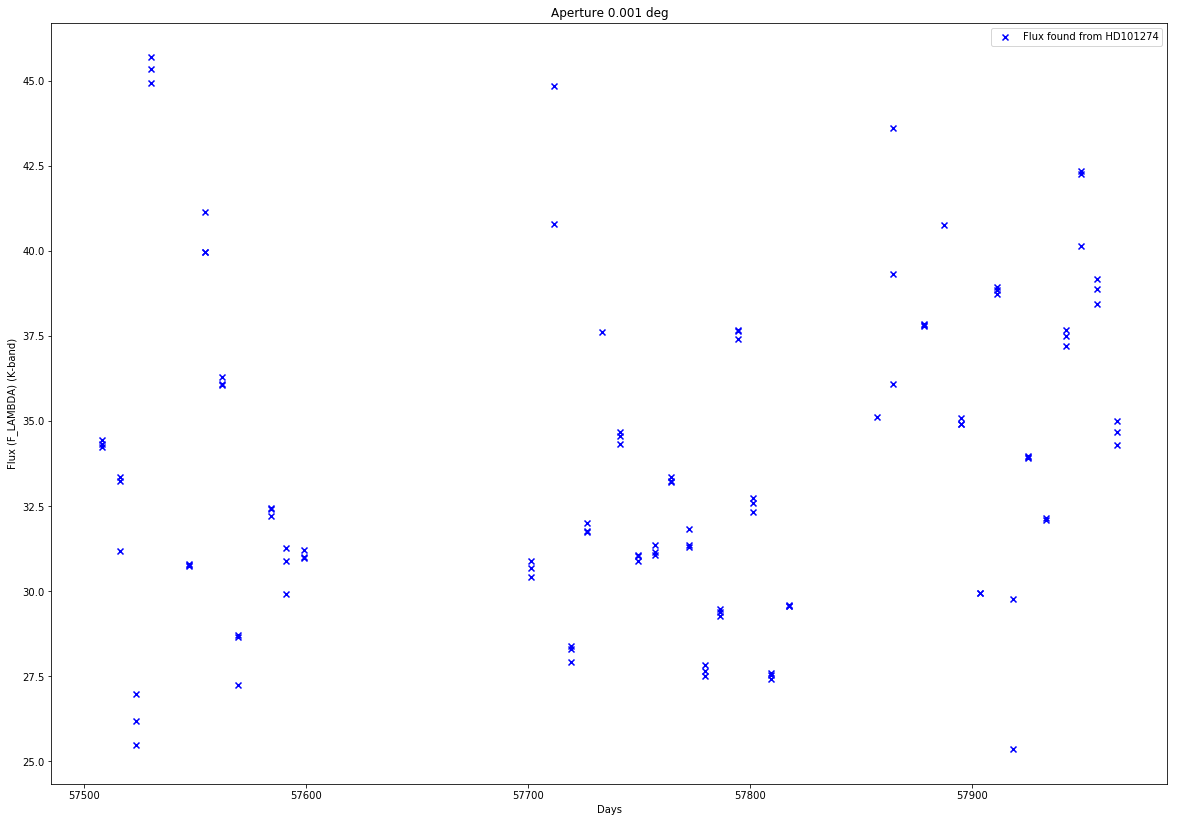

[  2.77901393e-15   2.30787555e-15   2.43419980e-15              nan
   2.36155234e-15   2.33767100e-15   2.40294161e-15   2.28817949e-15
   2.21750911e-15              nan   2.22653298e-15   2.44277697e-15
   2.21233929e-15              nan   2.40857662e-15   2.42478518e-15
   2.30458363e-15   2.41330075e-15   2.34978280e-15   2.48555184e-15
   2.49554329e-15              nan   2.39707494e-15   2.38023070e-15
   2.29613110e-15              nan   2.28324349e-15              nan
   2.31047913e-15   2.69475353e-15   2.45435114e-15   2.51299761e-15
              nan   2.44420159e-15              nan              nan
              nan   2.30029748e-15   2.43059452e-15   2.47233334e-15
              nan   2.45134660e-15   2.49533669e-15   2.35222238e-15
   2.50987704e-15              nan   2.39099159e-15   2.52682357e-15
              nan   2.38050288e-15   2.37550491e-15              nan
   2.47747522e-15   2.44572123e-15              nan   2.30759732e-15
   2.42479426e-15   2.50207103e-15

In [36]:
plt.figure(figsize=(20,14))
#plt.scatter(date,np.array(ABS_FLUX_LAMBDA_1),marker='x',\
#            color='b',label='Flux found from HD101274')
plt.scatter(date,np.array(ABS_FLUX_LAMBDA_2),marker='x',\
            color='r',label='Flux found from Tycho-2 7740-22-1')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_3),marker='x',\
            color='g',label='Flux found from Tycho-2 7740-529-1')
plt.scatter(date_1,ABS_FLUX_LAMBDA_1_1,marker='o',\
            color='b',label='Flux found from SEX HD101274')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_2_1),marker='o',\
            color='r',label='Flux found from SEX Tycho-2 7740-22-1')
#plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_3_1),marker='o',\
#            color='g',label='Flux found from Tycho-2 7740-529-1')
plt.xlabel('Days')
plt.ylabel('Flux (F_LAMBDA) (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
plt.ylim([0.05*10**(-14),0.12*10**(-14)])
#plt.xlim([57580,57600])
plt.legend()
plt.show()

plt.figure(figsize=(20,14))
plt.scatter(date,np.array(SNR1),marker='x',\
            color='b',label='Flux found from HD101274')
plt.xlabel('Days')
plt.ylabel('Flux (F_LAMBDA) (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
#plt.ylim([0.15,0.20])
#plt.xlim([57580,57600])
plt.legend()
plt.show()

num = np.nanargmax(ABS_FLUX_LAMBDA_2_1)

print ABS_FLUX_LAMBDA_2
print ABS_FLUX_LAMBDA_2[num]
print num
print date[num]
print quasJ[num]


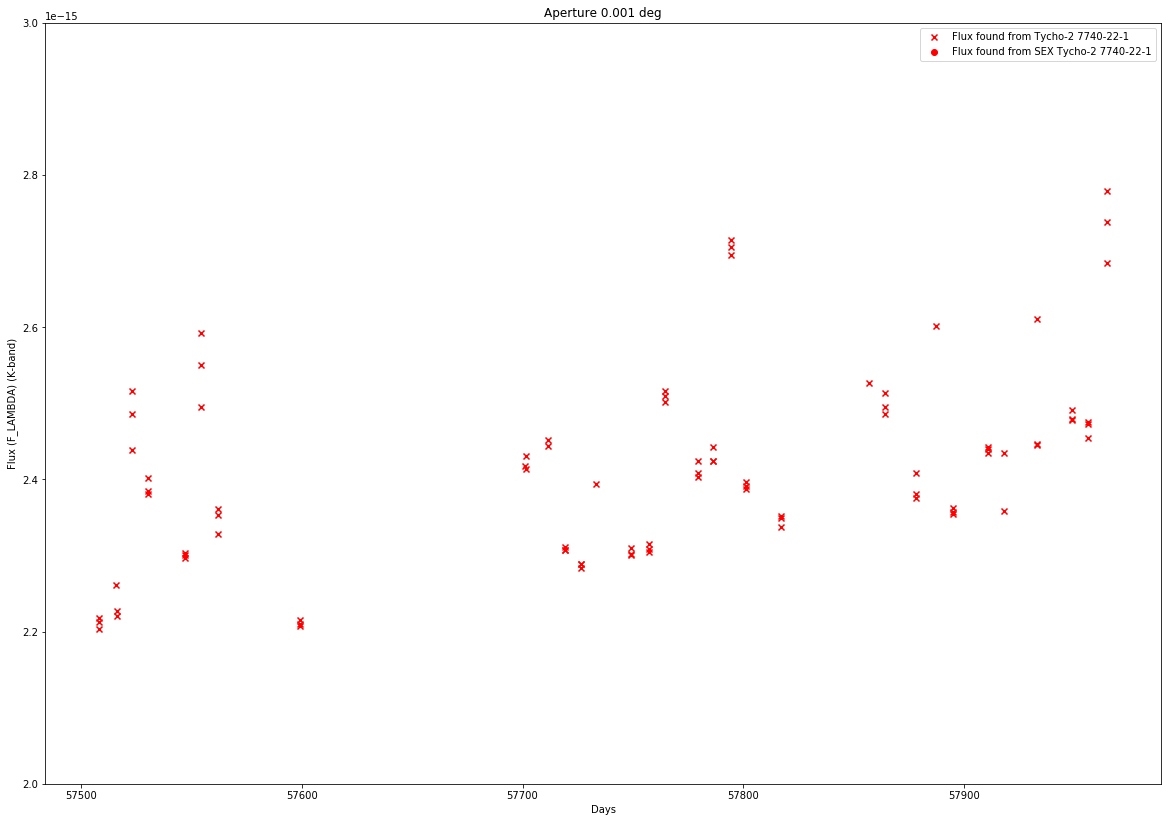

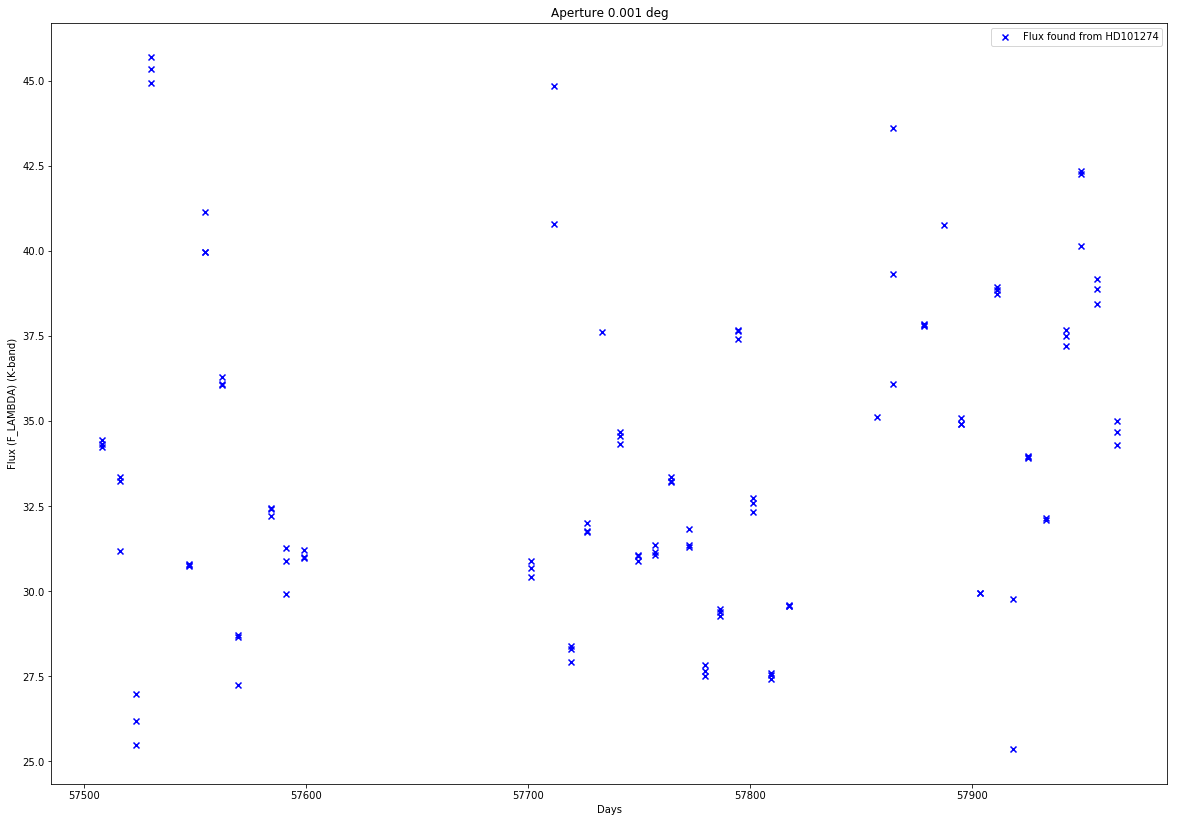

[  2.77901393e-15   2.30787555e-15   2.43419980e-15              nan
   2.36155234e-15   2.33767100e-15   2.40294161e-15   2.28817949e-15
   2.21750911e-15              nan   2.22653298e-15   2.44277697e-15
   2.21233929e-15              nan   2.40857662e-15   2.42478518e-15
   2.30458363e-15   2.41330075e-15   2.34978280e-15   2.48555184e-15
   2.49554329e-15              nan   2.39707494e-15   2.38023070e-15
   2.29613110e-15              nan   2.28324349e-15              nan
   2.31047913e-15   2.69475353e-15   2.45435114e-15   2.51299761e-15
              nan   2.44420159e-15              nan              nan
              nan   2.30029748e-15   2.43059452e-15   2.47233334e-15
              nan   2.45134660e-15   2.49533669e-15   2.35222238e-15
   2.50987704e-15              nan   2.39099159e-15   2.52682357e-15
              nan   2.38050288e-15   2.37550491e-15              nan
   2.47747522e-15   2.44572123e-15              nan   2.30759732e-15
   2.42479426e-15   2.50207103e-15

In [37]:
plt.figure(figsize=(20,14))
#plt.scatter(date,np.array(ABS_FLUX_LAMBDA_1),marker='x',\
#            color='b',label='Flux found from HD101274')
plt.scatter(date,np.array(ABS_FLUX_LAMBDA_2),marker='x',\
            color='r',label='Flux found from Tycho-2 7740-22-1')
#plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_3),marker='x',\
#            color='g',label='Flux found from Tycho-2 7740-529-1')
#plt.scatter(date_1,ABS_FLUX_LAMBDA_1_1,marker='o',\
#            color='b',label='Flux found from SEX HD101274')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_2_1),marker='o',\
            color='r',label='Flux found from SEX Tycho-2 7740-22-1')
#plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_3_1),marker='o',\
#            color='g',label='Flux found from Tycho-2 7740-529-1')
plt.xlabel('Days')
plt.ylabel('Flux (F_LAMBDA) (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
plt.ylim([0.2*10**(-14),0.3*10**(-14)])
#plt.xlim([57580,57600])
plt.legend()
plt.show()

plt.figure(figsize=(20,14))
plt.scatter(date,np.array(SNR1),marker='x',\
            color='b',label='Flux found from HD101274')
plt.xlabel('Days')
plt.ylabel('Flux (F_LAMBDA) (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
#plt.ylim([0.15,0.20])
#plt.xlim([57580,57600])
plt.legend()
plt.show()

num = np.nanargmax(ABS_FLUX_LAMBDA_2_1)

print ABS_FLUX_LAMBDA_2
print ABS_FLUX_LAMBDA_2[num]
print num
print date[num]
print quasJ[num]


In [38]:
#print comp_array
comp_array_2 = np.zeros((len(comp_array[:,0]),13))
#comp_array_2[0,0] = comp_array[0,0]
tjek = 0
acceptance = 0.01

for i in range(len(comp_array)):
    if comp_array[i,0] != comp_array_2[tjek,0]:
        comp_array_2[tjek,0] = comp_array[i,0]
        com1 = []
        com2 = []
        com3 = []
        for j in range(len(comp_array)):
            if comp_array_2[tjek,0] == comp_array[j,0]:
                com1.append(comp_array[j,1])
                com2.append(comp_array[j,2])
                com3.append(comp_array[j,3])
        comp_array_2[tjek,1] = np.mean(com1)
        comp_array_2[tjek,2] = np.std(com1)
        if comp_array_2[tjek,2]/float(comp_array_2[tjek,1]) > acceptance or float(comp_array_2[tjek,1]) < 0:
            comp_array_2[tjek,1] = float('nan')
            comp_array_2[tjek,2] = float('nan')
        comp_array_2[tjek,3] = np.mean(com2)
        comp_array_2[tjek,4] = np.std(com2)
        if comp_array_2[tjek,4]/float(comp_array_2[tjek,3]) > acceptance or float(comp_array_2[tjek,3]) < 0:
            comp_array_2[tjek,3] = float('nan')
            comp_array_2[tjek,4] = float('nan')
        comp_array_2[tjek,5] = np.mean(com3)
        comp_array_2[tjek,6] = np.std(com3)
        if comp_array_2[tjek,6]/float(comp_array_2[tjek,5]) > acceptance or float(comp_array_2[tjek,5]) < 0:
            comp_array_2[tjek,5] = float('nan')
            comp_array_2[tjek,6] = float('nan')
        tjek = tjek + 1

comp_array_3 = np.zeros((len(flucompsta2),3))
#print comp_array_3
#comp_array_2[0,0] = comp_array[0,0]
tjek = 0
acceptance = 0.005
print flucompsta2
for i in range(len(flucompsta2)):
    if int(date[i]) != int(comp_array_3[tjek,0]):
        #print 'YES'
        comp_array_3[tjek,0] = int(date[i])
        #print comp_array_3[tjek,0]
        com1 = []
        for j in range(len(flucompsta2)):
            if comp_array_2[tjek,0] == int(date[j]):
                com1.append(flucompsta2[j])
        comp_array_3[tjek,1] = np.mean(com1)
        comp_array_3[tjek,2] = np.std(com1)
        #print comp_array_3[tjek,2]
        if comp_array_3[tjek,2]/float(comp_array_3[tjek,1]) > acceptance or float(comp_array_3[tjek,1]) < 0:
            comp_array_3[tjek,1] = float('nan')
            comp_array_3[tjek,2] = float('nan')
        tjek = tjek + 1




[ 1.0926621   0.90741832  0.95708692         nan  0.92852315  0.9191334
  0.94479672  0.89967416  0.87188774         nan  0.87543577  0.96045932
  0.86985505         nan  0.94701231  0.95338525  0.90612399  0.94886976
  0.92389556  0.97727769  0.98120616         nan  0.94249004  0.93586717
  0.9028006          nan  0.8977334          nan  0.90844201  1.05953232
  0.96501009  0.98806891         nan  0.96101946         nan         nan
         nan  0.90443875  0.95566938  0.97208039         nan  0.96382876
  0.98112493  0.92485476  0.98684195         nan  0.94009817  0.99350505
         nan  0.93597418  0.93400906         nan  0.9741021   0.96161695
         nan  0.90730893  0.95338882  0.98377276  0.90005811  0.96174535
  0.98948936  0.86609716  0.88881658  0.90469332  0.91010197  0.94677149
  1.05541704  0.94452375  0.96051269  0.87121999  0.97929362  0.92545941
  0.98954041  0.95056521         nan  1.06757113         nan  0.93782625
  0.97725418  1.01902546  0.90509559  0.95943539    

/home/lynge/.local/lib/python2.7/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


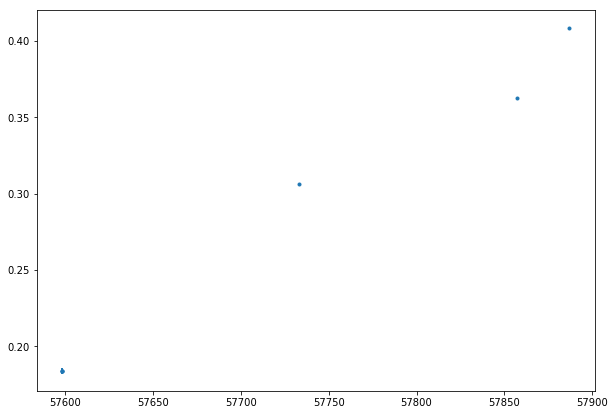

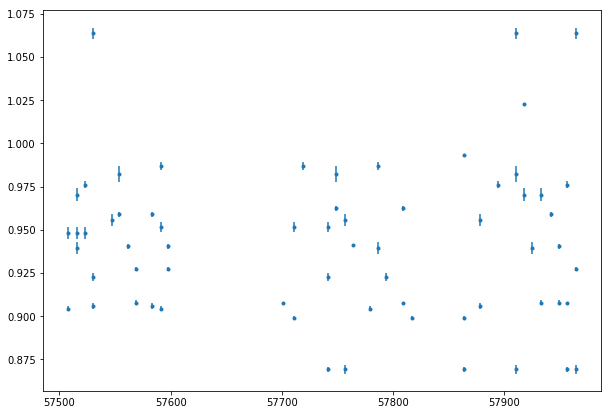

In [39]:
plt.figure(figsize=(10,7))
plt.errorbar(comp_array_2[:,0],comp_array_2[:,3],yerr=comp_array_2[:,4],fmt='.')
#plt.ylim([0.02,0.07])
plt.show()

plt.figure(figsize=(10,7))
plt.errorbar(comp_array_3[:,0],comp_array_3[:,1],yerr=comp_array_3[:,2],fmt='.')
#plt.ylim([0.02,0.07])
plt.show()

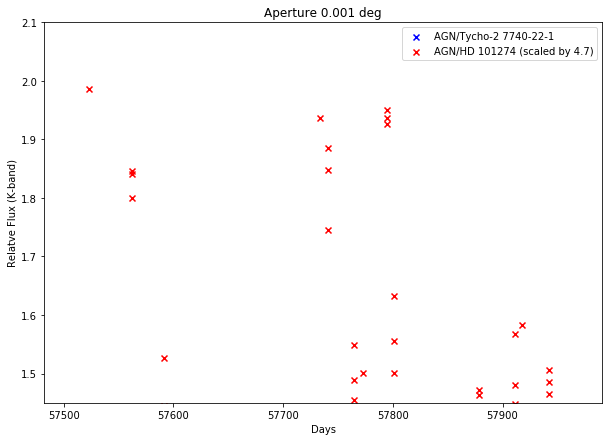

In [40]:

plt.figure(figsize=(10,7))
plt.scatter(date,flucompsta2,marker='x',\
            color='b',label='AGN/Tycho-2 7740-22-1')
plt.scatter(date,flucompsta1*6.2,marker='x',\
            color='r',label='AGN/HD 101274 (scaled by 4.7)')
#plt.scatter(date,flucompsta4*2.2,marker='x',\
#            color='g',label='AGN/Tycho-2 7740-529-1 (scaled by 2.2)')
plt.xlabel('Days')
plt.ylabel('Relatve Flux (K-band)')
plt.title('Aperture 0.001 deg')
plt.ylim([1.45,2.1])
plt.legend()
plt.show()


